# Runing

# DQN Implementation

In [9]:
from preprocessing import USER_STREAM_CONTEXT, ITEM_DF, ITEM_STREAM_DF, REAL_BOUGHT_DF, LAST_BOUGHT_STREAM, LB_ITEMS, USER_LIST, LB_CE, STREAM_LIST
from utils import gen_exist_series, get_full_state, get_reward, calculate_interest_change, get_input, model_predict_top10, INPUT_DF_COL
from replay import ReplayBuffer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import itertools
from datetime import datetime
import pytz

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:\
      {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:      /device:GPU:0


## Train DQN model
* Input: `user_df` 253, `item_df` 231(BERT: 768), interact (?), `reward` 1
* Output: recommend a list of items
* Methods Needed
    * Environment Function
    * Choose Action
    * Store Transition
    * Learn

In [3]:
### Training Process

def train(model, exp_replay, epochs, batch_size, num_episode=1000, verbose=1, reward_set='strict', hist=[], c_hist=[], rec_list=[]):
  # total_actions = ITEM_DF.shape[0]
  total_episodes = len(USER_LIST)
  # Reset win counter
  c_win_cnt = 0

  for e in range(epochs):
    rec_cnt = 0
    win_cnt = 0
    loss = 0.
    # TODO/MAIN: Apply user preference changes as epsilon
    # epsilon for exploration - dependent inversely on the training epoch
    epsilon = 4 / ((e + 1) ** (1 / 2))

    # handling episodes by assigning users from USER_LIST
    # Each user represent an Episode
    episodes = random.sample(range(total_episodes), num_episode)

    print(f'Epoch {e} started.   Time: {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
    # ------------------- Episode (User) -------------------------------
    for user_episode in episodes:
      # game_over = False
      # get episode data by user phone number
      user_phone = USER_LIST[user_episode]
      user_all_streams = USER_STREAM_CONTEXT.xs(user_phone, level="聯絡電話")
      stream_list = user_all_streams.index
      final_stream = LAST_BOUGHT_STREAM.loc[user_phone, '場次']
      
      # ----------------- Runs (User x All_Stream) ---------------------
      for i, stream in enumerate(stream_list):          
        game_over = stream == final_stream
                
        # Get full state: current_state = user_stream + item_stream
        # 用上一場紀錄預測下一場直播會購買的商品
        current_state = get_full_state(user_all_streams, stream_list, i)
        stream_items = current_state['cand_item']
        
        # --------------- Explore/Exploit Section ----------------------
        if np.random.rand() <= epsilon:
          # Explore by randomly select 10/n items from candidate_items
          # Get all items from the stream
          sample_actions = random.sample(stream_items, 10) if len(stream_items) > 10 else stream_items
          action_ids = gen_exist_series(sample_actions, stream_items)
        else:
          # Exploit by choosing action from the model's prediction
          pred_actions = model_predict_top10(model, current_state)
          action_ids = gen_exist_series(pred_actions, stream_items)

        # --------------- Get next state & info to store ---------------
        reward = get_reward(user_phone, stream, action_ids)
        next_state = get_full_state(user_all_streams, stream_list, i+1) if not game_over else []

        rec_cnt += 1
        if sum(reward) > 0:
          c_win_cnt += 1
          win_cnt += 1

        # --------------- Calculating Interest Changes -----------------
        interest_score = calculate_interest_change(user_all_streams, stream_list, i)

        # --------------- Store Experience -----------------------------
        exp_replay.remember(interest_score,
                            [current_state, action_ids, reward, next_state],
                            game_over)
        

        # --------------- Load batch of experiences --------------------
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
        # train model on experiences
        batch_loss = model.train_on_batch(inputs, targets)
        loss += batch_loss
            
    if verbose > 0:
      print(f'Epoch: {e}/{epochs} | Loss {loss} | Win count {win_cnt} | Rec count {rec_cnt} | Time {datetime.now(pytz.timezone("Asia/Taipei")).strftime("%H:%M:%S")}')
    
    # Track win history to later check if our model is improving at the game over time.
    hist.append(win_cnt)
    c_hist.append(c_win_cnt)
    rec_list.append(rec_cnt)

In [2]:
pd.set_option('mode.chained_assignment', None)

# parameters
MAX_MEMORY = 1000  # Maximum number of experiences we are storing
BATCH_SIZE = 2  # Number of experiences we use for training per batch
EPOCH = 50
TOTAL_ACTIONS = 1 # probability of ordering
NUM_EPISODE = 100
HIDDEN_SIZE = 512


warnings.simplefilter(action='ignore', category=FutureWarning)

### Main Method

In [ ]:
exp_replay = ReplayBuffer(max_memory=MAX_MEMORY)# Our model's architecture parameters
input_size = 473 # The input shape for model - this comes from the output shape of the CNN Mobilenet

# Setting up the model with keras.
model = keras.Sequential()
model.add(Dense(HIDDEN_SIZE, input_shape=(input_size,), activation='relu'))
model.add(Dense(HIDDEN_SIZE, activation='tanh'))
model.add(Dense(TOTAL_ACTIONS))
model.compile(Adam(learning_rate=.000001), "mse")

hist = []
c_hist = []
rec_list = []

# Training the model
train(model, 
      exp_replay, 
      epochs=EPOCH, 
      batch_size=BATCH_SIZE, 
      num_episode=NUM_EPISODE, 
      verbose=1, 
      reward_set='strict',
      hist=hist,
      c_hist=c_hist,
      rec_list=rec_list)
plt.plot(range(EPOCH), hist)

Epoch 0 started.   Time: 13:28:43
Epoch: 0/50 | Loss 195.39991076570004 | Win count 301 | Rec count 1233 | Time 13:48:39
Epoch 1 started.   Time: 13:48:39
Epoch: 1/50 | Loss 158.69009656086564 | Win count 276 | Rec count 969 | Time 14:04:29
Epoch 2 started.   Time: 14:04:29
Epoch: 2/50 | Loss 170.69441264867783 | Win count 282 | Rec count 1055 | Time 14:21:35
Epoch 3 started.   Time: 14:21:35
Epoch: 3/50 | Loss 170.46278010495007 | Win count 342 | Rec count 1194 | Time 14:41:02
Epoch 4 started.   Time: 14:41:02
Epoch: 4/50 | Loss 122.63620313443244 | Win count 296 | Rec count 975 | Time 14:56:57
Epoch 5 started.   Time: 14:56:57
Epoch: 5/50 | Loss 148.3875130917877 | Win count 383 | Rec count 1264 | Time 15:17:34
Epoch 6 started.   Time: 15:17:34
Epoch: 6/50 | Loss 103.8623224766925 | Win count 262 | Rec count 893 | Time 15:32:11
Epoch 7 started.   Time: 15:32:11
Epoch: 7/50 | Loss 135.9428073023446 | Win count 355 | Rec count 1362 | Time 15:54:31
Epoch 8 started.   Time: 15:54:31
Epoc

In [ ]:
c_hist[-1]/sum(rec_list)

In [ ]:
bert = np.load('../../data/jambo_iname2embedding.npy', allow_pickle=True)[None][0]

In [ ]:
list(bert.keys())[:2]

In [ ]:
bert['【商城】W08-76 休閒毯'].shape

In [ ]:
with open('9.txt', 'w') as f:
  f.write(' hist: \n')
  f.write(', '.join([str(a) for a in hist]))
  f.write('\n c_hist: \n')
  f.write(', '.join([str(a) for a in c_hist]))
  f.write('\n rec_list: \n')
  f.write(', '.join([str(a) for a in rec_list]))


In [11]:
c_hist[-1]/sum(rec_list)

0.2312752753498947

In [3]:
hist9 = [301, 276, 282, 342, 296, 383, 262, 355, 290, 345, 248, 279, 288, 349, 307, 321, 345, 275, 335, 360, 297, 254, 246, 248, 232, 214, 267, 272, 228, 228, 214, 225, 222, 187, 187, 183, 153, 164, 205, 188, 171, 205, 151, 171, 170, 163, 211, 166, 150, 199]
c_hist9 = [301, 577, 859, 1201, 1497, 1880, 2142, 2497, 2787, 3132, 3380, 3659, 3947, 4296, 4603, 4924, 5269, 5544, 5879, 6239, 6536, 6790, 7036, 7284, 7516, 7730, 7997, 8269, 8497, 8725, 8939, 9164, 9386, 9573, 9760, 9943, 10096, 10260, 10465, 10653, 10824, 11029, 11180, 11351, 11521, 11684, 11895, 12061, 12211, 12410]
rec_list9 = [1233, 969, 1055, 1194, 975, 1264, 893, 1362, 1047, 1117, 953, 985, 1031, 1193, 1086, 1008, 1299, 1045, 1241, 1229, 1029, 1072, 1028, 1095, 1109, 1000, 1147, 1131, 965, 1074, 1118, 1100, 1134, 972, 929, 1057, 896, 957, 1157, 977, 1082, 1200, 910, 1110, 1009, 1049, 1086, 995, 963, 1129]
len(hist9)

50

In [4]:
hist15 = [331, 499, 434, 368, 393, 287, 317, 300, 445, 417, 435, 407, 394, 420, 406, 341, 362, 315, 310, 328, 304, 381, 343, 334, 296, 373, 252, 280, 245, 288, 317, 297, 271, 308]
c_hist15 = [331, 830, 1264, 1632, 2025, 2312, 2629, 2929, 3374, 3791, 4226, 4633, 5027, 5447, 5853, 6194, 6556, 6871, 7181, 7509, 7813, 8194, 8537, 8871, 9167, 9540, 9792, 10072, 10317, 10605, 10922, 11219, 11490, 11798]
rec_list15 = [1320, 1593, 1378, 1281, 1416, 1151, 1122, 1140, 1476, 1343, 1381, 1340, 1351, 1340, 1357, 1099, 1270, 1218, 1150, 1265, 1169, 1401, 1276, 1416, 1266, 1454, 1093, 1365, 1163, 1327, 1377, 1299, 1289, 1468]
len(hist15)

34

In [18]:
hist25 = [487, 499, 577, 502, 584, 461, 535, 557, 586, 519, 398, 647, 485, 460, 536, 451, 514, 539]
c_hist25 = [487, 986, 1563, 2065, 2649, 3110, 3645, 4202, 4788, 5307, 5705, 6352, 6837, 7297, 7833, 8284, 8798, 9337]
rec_list25 = [1423, 1805, 1690, 1615, 1815, 1373, 1749, 1900, 1819, 1603, 1399, 1907, 1541, 1601, 1656, 1493, 1743, 1777]
len(c_hist25)

18

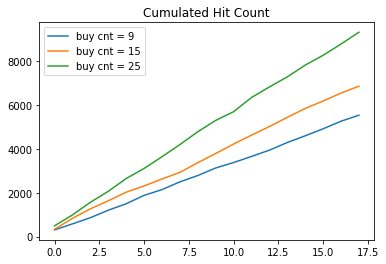

In [19]:
plt.plot(range(18), c_hist9[:18], label='buy cnt = 9')
plt.plot(range(18), c_hist15[:18], label='buy cnt = 15')
plt.plot(range(18), c_hist25, label='buy cnt = 25')
plt.title('Cumulated Hit Count')
plt.legend()
plt.show()

In [23]:
avg_ratio9 = [a/b for a, b in zip(hist9[:18], rec_list9[:18])]
avg_ratio15 = [a/b for a, b in zip(hist15[:18], rec_list15[:18])]
avg_ratio25 = [a/b for a, b in zip(hist25[:18], rec_list25[:18])]

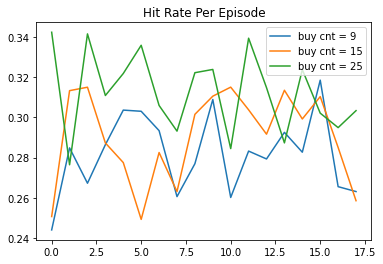

In [24]:
plt.plot(range(18), avg_ratio9, label='buy cnt = 9')
plt.plot(range(18), avg_ratio15, label='buy cnt = 15')
plt.plot(range(18), avg_ratio25, label='buy cnt = 25')
plt.title('Hit Rate Per Episode')
plt.legend()
plt.show()

In [28]:
temp_dict={9: avg_ratio9,
 15: avg_ratio15,
 25: avg_ratio25}

In [29]:
df = pd.DataFrame.from_dict(temp_dict)

In [32]:
df.describe()

,9,15,25
count,18.000000,18.000000,18.000000
mean,0.281912,0.290429,0.312401
std,0.019502,0.022639,0.020372
min,0.244120,0.249348,0.276454
25%,0.266016,0.278790,0.296689
50%,0.282969,0.295413,0.312783
75%,0.293180,0.310445,0.323744
max,0.318452,0.314989,0.342235
